In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from classifiers import *

Load the dataset and select the features and target to use for the classification.

In [16]:
import pandas as pd

df = pd.read_csv('../data/new_incidents.csv')

# drop useless columns
df = df.drop(columns=['notes', 'date'])

poverty_df = pd.read_csv('../data/poverty_cleaned.csv')
df = df.merge(poverty_df, on=['state', 'year'])

In [17]:
# convert state string to int
df['state'] = df['state'].astype('category')
df['state'] = df['state'].cat.codes

df['city_or_county'] = df['city_or_county'].astype('category')
df['city_or_county'] = df['city_or_county'].cat.codes

df['incident_category'] = df['incident_category'].astype('category')
df['incident_category'] = df['incident_category'].cat.codes

df["any_killed"] = df["n_killed"] > 0

df = df.dropna()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159432 entries, 0 to 183652
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   state                   159432 non-null  int8   
 1   city_or_county          159432 non-null  int16  
 2   latitude                159432 non-null  float64
 3   longitude               159432 non-null  float64
 4   congressional_district  159432 non-null  float64
 5   avg_age_participants    159432 non-null  float64
 6   n_participants_adult    159432 non-null  float64
 7   n_males                 159432 non-null  float64
 8   n_females               159432 non-null  float64
 9   n_killed                159432 non-null  int64  
 10  n_injured               159432 non-null  int64  
 11  n_arrested              159432 non-null  int64  
 12  n_unharmed              159432 non-null  int64  
 13  n_participants          159432 non-null  int64  
 14  year                    1

In [19]:
input_columns = ['state', 'longitude', 'latitude', 'year', 'month', 'n_participants',
                 'n_participants_adult', 'n_minors',
                 'n_males', 'n_females',
                 'povertyPercentage', 'n_arrested', 'n_injured']

target_column = ['any_killed']

X = df[input_columns]
y = df[target_column]

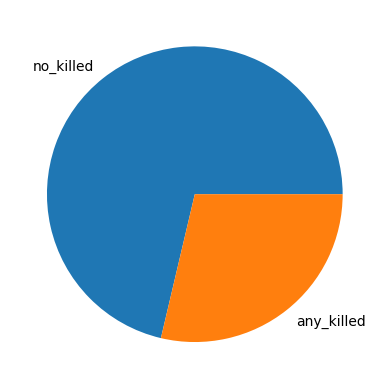

In [20]:
kill_value_count = df['any_killed'].value_counts()

labels = ['no_killed', 'any_killed']
plt.pie(kill_value_count, labels=labels)
plt.show()

## Prepare and split the dataset

Split the dataset into dev and test sets, then into train and validation (70/15/15). 
The distribution of the target variable is maintained in each set. We will try oversampling to reach the 50/50 ratio after the tests with the 70/30 split, as it's still a decent ratio.

In [21]:
import numpy as np

seed = 42
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=seed, test_size=0.15, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=seed, test_size=0.18,
                                                  stratify=y_dev)  # for manual cross-validation

print('Dev set size:', len(y_dev), '- Killing ratio:', round(np.count_nonzero(y_dev) / len(y_dev), 2))
print('     Train set size:', len(y_train), '- Killing ratio:', round(np.count_nonzero(y_train) / len(y_train), 2))
print('     Validation set size:', len(y_val), '- Killing ratio:', round(np.count_nonzero(y_val) / len(y_val), 2))
print('Test set size:', len(y_test), '- Killing ratio:', round(np.count_nonzero(y_test) / len(y_test), 2))

Dev set size: 135517 - Killing ratio: 0.29
     Train set size: 111123 - Killing ratio: 0.29
     Validation set size: 24394 - Killing ratio: 0.29
Test set size: 23915 - Killing ratio: 0.29


Standardize the input data to avoid the bias given by the range of the different attribute

In [22]:
scaler = StandardScaler()
X_std_dev = scaler.fit_transform(X_dev)
X_std_train = scaler.fit_transform(X_train)
X_std_val = scaler.fit_transform(X_val)
X_std_test = scaler.fit_transform(X_test)

# ravel() is used to convert the y arrays from 2D to 1D
y_dev = y_dev.values.ravel()
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()


NB: run all above before running a classifier

# KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


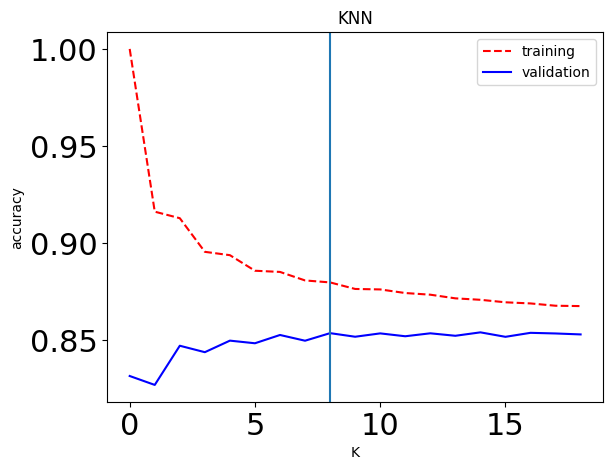

In [20]:
knn_list = []
acc_tr_list = []
acc_val_list = []

for x in range(3, 18):
    # Create KNN classifier
    knn = KNeighborsClassifier(n_neighbors=x)
    knn.fit(X_std_train, y_train)
    acc_tr = knn.score(X_std_train, y_train)
    acc_val = knn.score(X_std_val, y_val)
    # append results
    knn_list.append(knn)
    acc_tr_list.append(acc_tr)
    acc_val_list.append(acc_val)

plt.plot(range(len(acc_tr_list)), acc_tr_list, 'r--', label='training')
plt.plot(range(len(acc_val_list)), acc_val_list, 'b-', label='validation')
plt.ylabel('accuracy')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('KNN')
plt.axvline(8)
plt.legend(loc="upper right")
plt.show()

Also try to perform k-fold cross-validation for each k

In [19]:
cv_scores = []
for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_std_dev, y_dev, cv=5)  # 5-fold cross-validation
    cv_scores.append(scores.mean())

best_k_cv = np.argmax(cv_scores) + 1  # Add 1 to get the actual k value
best_accuracy_cv = max(cv_scores)

print(f"The best k based on cross-validation accuracy is: {best_k_cv}")
print(f"Corresponding cross-validation accuracy: {best_accuracy_cv}")

The best k based on cross-validation accuracy is: 15
Corresponding cross-validation accuracy: 0.852542498138088


Test both k (8 and 15) and see which one is better

In [55]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_std_dev, y_dev)
acc_tr = knn.score(X_std_dev, y_dev)
acc_val = knn.score(X_std_test, y_test)
print(f"Training accuracy: {acc_tr}")
print(f"Test accuracy: {acc_val}")

Training accuracy: 0.8810038592944058
Test accuracy: 0.8593769600669037


In [56]:
knn_2 = KNeighborsClassifier(n_neighbors=15)
knn_2.fit(X_std_dev, y_dev)
acc_tr = knn_2.score(X_std_dev, y_dev)
acc_val = knn_2.score(X_std_test, y_test)
print(f"Training accuracy: {acc_tr}")
print(f"Test accuracy: {acc_val}")

Training accuracy: 0.8725916305703344
Test accuracy: 0.8627639556763538


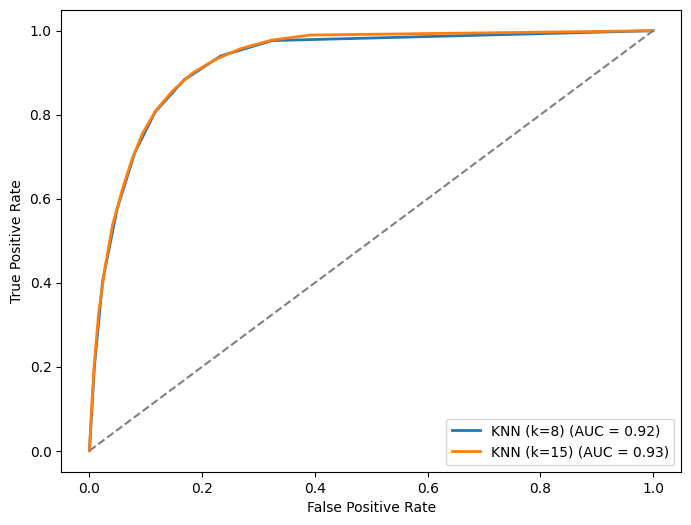

In [57]:
plot_roc_curves(y_test, [
    (knn.predict_proba(X_std_test)[:, 1], 'KNN (k=8)'),
    (knn_2.predict_proba(X_std_test)[:, 1], 'KNN (k=15)')
])

# Bayesian Classifier

In [66]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

gnb = GaussianNB()
y_pred = gnb.fit(X_std_train, y_train).predict(X_std_val)
print(classification_report(y_pred, y_val, target_names=labels))

              precision    recall  f1-score   support

   no_killed       0.92      0.75      0.82     21318
  any_killed       0.23      0.53      0.33      3076

    accuracy                           0.72     24394
   macro avg       0.58      0.64      0.58     24394
weighted avg       0.83      0.72      0.76     24394


In [67]:
bnb = BernoulliNB()
y_pred = bnb.fit(X_std_train, y_train).predict(X_std_val)
print(classification_report(y_pred, y_val, target_names=labels))

              precision    recall  f1-score   support

   no_killed       0.89      0.77      0.82     19959
  any_killed       0.35      0.55      0.43      4435

    accuracy                           0.73     24394
   macro avg       0.62      0.66      0.63     24394
weighted avg       0.79      0.73      0.75     24394


In [68]:
# test BernoulliNB on test set
y_pred = bnb.fit(X_std_dev, y_dev).predict(X_std_test)
print(classification_report(y_pred, y_test, target_names=labels))

              precision    recall  f1-score   support

   no_killed       0.89      0.78      0.83     19556
  any_killed       0.36      0.57      0.44      4359

    accuracy                           0.74     23915
   macro avg       0.62      0.67      0.63     23915
weighted avg       0.79      0.74      0.76     23915


# Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [68]:

dt_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}
best_score_dt, best_decision_tree = grid_search(DecisionTreeClassifier(), X_std_dev, y_dev, dt_params)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best parameters set found:
{'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 5, 'splitter': 'best'}
Best accuracy score found:
0.8618623858104645


0.8681998745557181


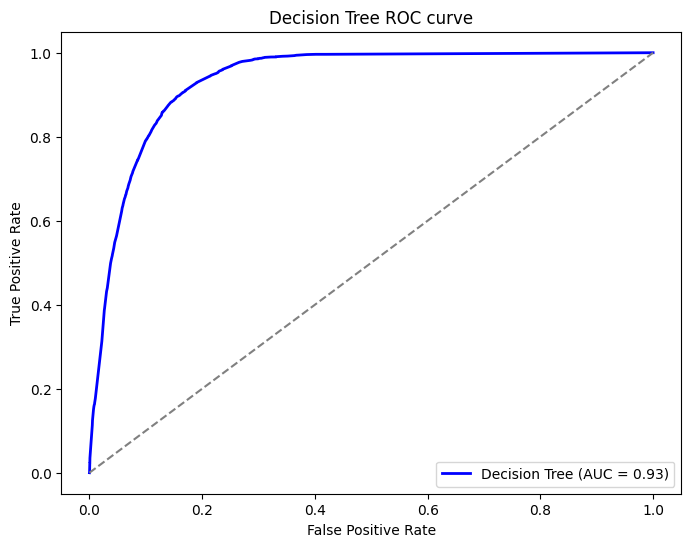

In [17]:
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features=None, min_samples_leaf=10,
                                       min_samples_split=5,
                                       splitter='best')
print(decision_tree.fit(X_std_dev, y_dev).score(X_std_test, y_test))

plot_roc_curve(y_test, decision_tree.predict_proba(X_std_test)[:, 1], 'Decision Tree')

# Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [69]:

rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['sqrt', 'log2']
}
best_score_rf, best_random_forest = grid_search(RandomForestClassifier(), X_std_dev, y_dev, rf_params)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best parameters set found:
{'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Best accuracy score found:
0.8745692715436295


0.8760192347898809


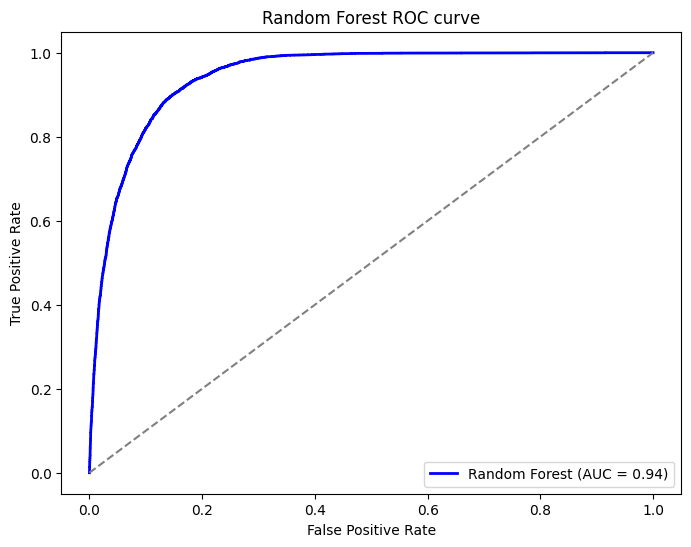

In [10]:
random_forest = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=150)
print(random_forest.fit(X_std_dev, y_dev).score(X_std_test, y_test))

plot_roc_curve(y_test, random_forest.predict_proba(X_std_test)[:, 1], 'Random Forest')


# SVM

In [32]:
import sklearn.svm as svms

In [9]:

svm_params = {
    "kernel": ["rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "C": [0.1, 0.5, 1, 5, 10, 20],
    "max_iter": [100, 200, 300]
}

best_score_svm, svm = grid_search(svms.SVC(), X_std_dev, y_dev, svm_params)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters set found:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 200}
Best accuracy score found:
0.6821432873091025


In [10]:
# use better implementation for large dataset (linear kernel)
lsvm_params = {
    "loss": ["hinge", "squared_hinge"],
    "C": [0.1, 0.5, 1, 5, 10],
}

best_score_lsvm, lsvm = grid_search(svms.LinearSVC(penalty='l2', dual='auto'), X_std_dev, y_dev, lsvm_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters set found:
{'C': 5, 'loss': 'hinge'}
Best accuracy score found:
0.7956713759234363


In [11]:
# polynomial kernel
psvm_params = {
    "degree": [2, 3, 4],
    "C": [0.1, 0.5, 1, 5],
    "max_iter": [100, 200],
    "gamma": ["scale", "auto"]
}
best_score_psvm, psvm = grid_search(svms.SVC(kernel='poly'), X_std_dev, y_dev, psvm_params)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters set found:
{'C': 1, 'degree': 4, 'gamma': 'auto', 'max_iter': 100}
Best accuracy score found:
0.45744013387252724


0.776458289776291


C:\Users\Hp\Desktop\DataMining\env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


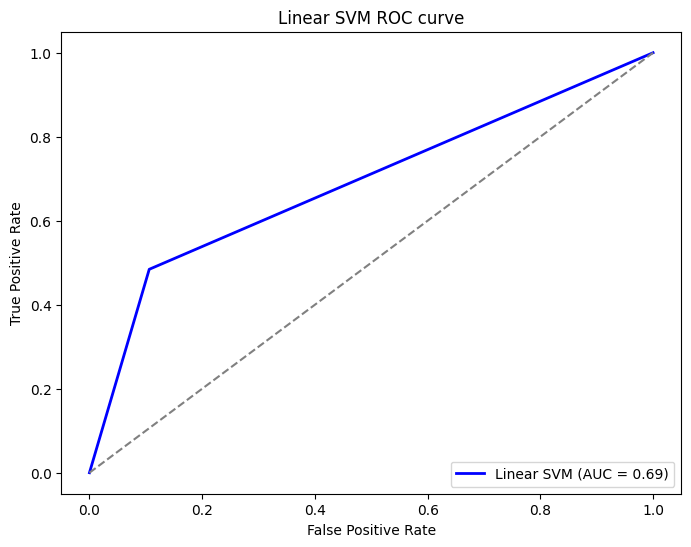

In [45]:
chosen_svm = svms.LinearSVC(penalty='l2', dual='auto', C=5, loss='hinge')
print(chosen_svm.fit(X_std_dev, y_dev).score(X_std_test, y_test))
plot_roc_curve(y_test, chosen_svm.predict(X_std_test), 'Linear SVM')

# Neural Network

In [46]:
from sklearn.neural_network import MLPClassifier

nn_params = {
    'hidden_layer_sizes': [(25, 25, 25), (50, 25, 25), (150, 100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [1e-3, 1e-4],
    'learning_rate': ['adaptive'],
    'max_iter': [50, 100]
}

best_score_nn, neural_network = grid_search(MLPClassifier(early_stopping=True), X_std_dev, y_dev, nn_params)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters set found:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 50, 'solver': 'adam'}
Best accuracy score found:
0.8687840302338697


In [11]:
from keras import Sequential
import keras as k
from keras.src import callbacks


def keras_mlp(train_X, train_y, val_X, val_y, optimizer, activation, dropout, epochs):
    neural_net = Sequential(
        [
            k.Input(shape=13),
            k.layers.Dense(units=50, activation=activation),
            k.layers.Dense(units=25, activation=activation),
            k.layers.Dense(units=25, activation=activation),
            k.layers.Dropout(dropout),
            k.layers.Dense(1, "sigmoid")
        ]
    )
    callback = [
        callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=7, cooldown=2, verbose=1, factor=0.25,
                                    min_lr=1e-7,
                                    min_delta=1e-5),
        callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1, min_delta=1e-5,
                                restore_best_weights=True)
    ]
    neural_net.compile(optimizer=optimizer, loss=k.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return neural_net.fit(train_X, train_y, batch_size=320, epochs=epochs, verbose=2, validation_data=(val_X, val_y),
                          callbacks=callback, use_multiprocessing=True, workers=10), neural_net

Epoch 1/150
348/348 - 3s - loss: 0.5973 - accuracy: 0.6777 - val_loss: 0.4875 - val_accuracy: 0.7720 - lr: 1.0000e-04 - 3s/epoch - 8ms/step
Epoch 2/150
348/348 - 2s - loss: 0.4641 - accuracy: 0.7818 - val_loss: 0.4375 - val_accuracy: 0.7956 - lr: 1.0000e-04 - 2s/epoch - 5ms/step
Epoch 3/150
348/348 - 2s - loss: 0.4387 - accuracy: 0.7978 - val_loss: 0.4213 - val_accuracy: 0.8058 - lr: 1.0000e-04 - 2s/epoch - 5ms/step
Epoch 4/150
348/348 - 2s - loss: 0.4200 - accuracy: 0.8069 - val_loss: 0.3981 - val_accuracy: 0.8128 - lr: 1.0000e-04 - 2s/epoch - 5ms/step
Epoch 5/150
348/348 - 1s - loss: 0.3979 - accuracy: 0.8134 - val_loss: 0.3716 - val_accuracy: 0.8226 - lr: 1.0000e-04 - 992ms/epoch - 3ms/step
Epoch 6/150
348/348 - 1s - loss: 0.3753 - accuracy: 0.8224 - val_loss: 0.3498 - val_accuracy: 0.8330 - lr: 1.0000e-04 - 985ms/epoch - 3ms/step
Epoch 7/150
348/348 - 1s - loss: 0.3593 - accuracy: 0.8288 - val_loss: 0.3355 - val_accuracy: 0.8411 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 8/150
34

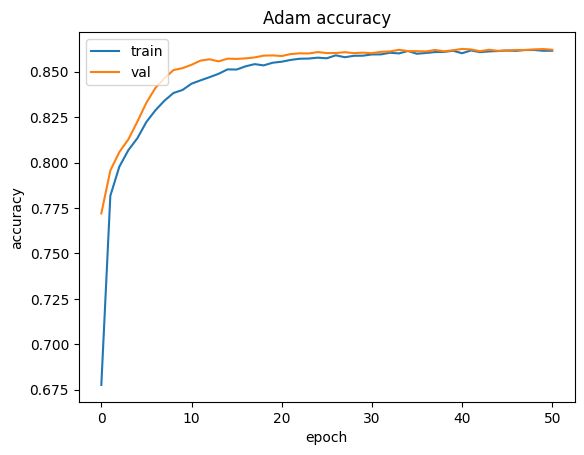

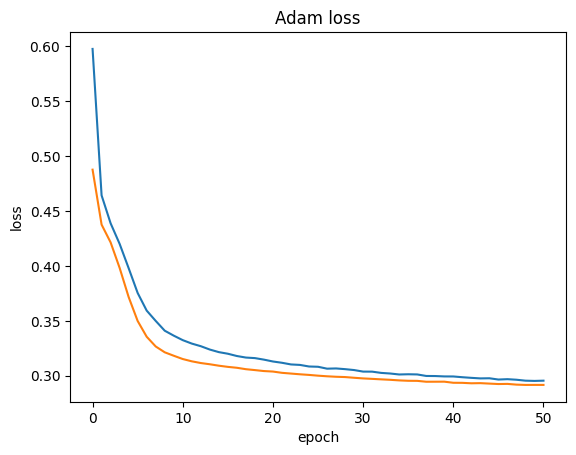

748/748 [==============================] - 1s 1ms/step - loss: 0.2888 - accuracy: 0.8654
[0.2887835204601288, 0.8654400706291199]


In [12]:
from keras.src.optimizers import Adam

history_adam, adam_model = keras_mlp(X_std_train, y_train, X_std_val, y_val,
                                Adam(learning_rate=1e-4), activation="tanh",
                                dropout=0.3, epochs=150)
plt.plot(history_adam.history['accuracy'])
plt.plot(history_adam.history['val_accuracy'])
plt.title('Adam accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.title('Adam loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

print(adam_model.evaluate(X_std_test, y_test))

Epoch 1/150
348/348 - 1s - loss: 0.5700 - accuracy: 0.6921 - val_loss: 0.4873 - val_accuracy: 0.7338 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 2/150
348/348 - 1s - loss: 0.4663 - accuracy: 0.7546 - val_loss: 0.4384 - val_accuracy: 0.7761 - lr: 0.0010 - 810ms/epoch - 2ms/step
Epoch 3/150
348/348 - 1s - loss: 0.4392 - accuracy: 0.7852 - val_loss: 0.4243 - val_accuracy: 0.7989 - lr: 0.0010 - 779ms/epoch - 2ms/step
Epoch 4/150
348/348 - 1s - loss: 0.4271 - accuracy: 0.7961 - val_loss: 0.4117 - val_accuracy: 0.8094 - lr: 0.0010 - 794ms/epoch - 2ms/step
Epoch 5/150
348/348 - 1s - loss: 0.4146 - accuracy: 0.8036 - val_loss: 0.3975 - val_accuracy: 0.8145 - lr: 0.0010 - 888ms/epoch - 3ms/step
Epoch 6/150
348/348 - 1s - loss: 0.4009 - accuracy: 0.8105 - val_loss: 0.3835 - val_accuracy: 0.8204 - lr: 0.0010 - 960ms/epoch - 3ms/step
Epoch 7/150
348/348 - 1s - loss: 0.3898 - accuracy: 0.8154 - val_loss: 0.3706 - val_accuracy: 0.8233 - lr: 0.0010 - 909ms/epoch - 3ms/step
Epoch 8/150
348/348 - 1s - los

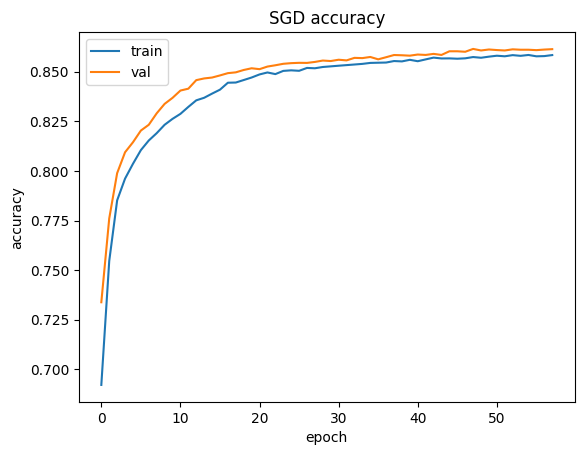

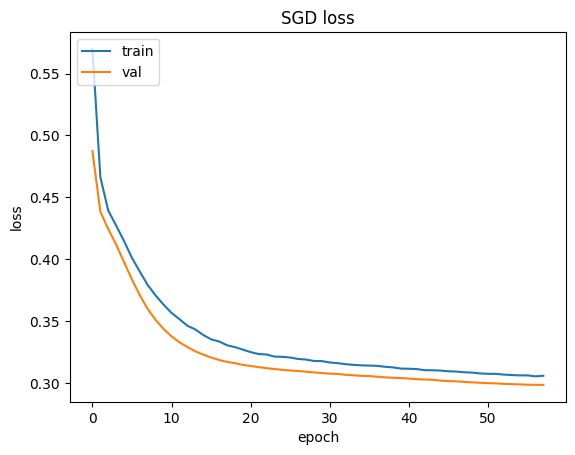

Epoch 1/30
424/424 - 1s - loss: 0.3079 - accuracy: 0.8582 - 847ms/epoch - 2ms/step
Epoch 2/30
424/424 - 1s - loss: 0.3081 - accuracy: 0.8576 - 826ms/epoch - 2ms/step
Epoch 3/30
424/424 - 1s - loss: 0.3076 - accuracy: 0.8576 - 843ms/epoch - 2ms/step
Epoch 4/30
424/424 - 1s - loss: 0.3072 - accuracy: 0.8583 - 906ms/epoch - 2ms/step
Epoch 5/30
424/424 - 1s - loss: 0.3076 - accuracy: 0.8584 - 826ms/epoch - 2ms/step
Epoch 6/30
424/424 - 1s - loss: 0.3074 - accuracy: 0.8584 - 848ms/epoch - 2ms/step
Epoch 7/30
424/424 - 1s - loss: 0.3075 - accuracy: 0.8578 - 797ms/epoch - 2ms/step
Epoch 8/30
424/424 - 1s - loss: 0.3070 - accuracy: 0.8584 - 755ms/epoch - 2ms/step
Epoch 9/30
424/424 - 1s - loss: 0.3061 - accuracy: 0.8580 - 744ms/epoch - 2ms/step
Epoch 10/30
424/424 - 1s - loss: 0.3071 - accuracy: 0.8585 - 765ms/epoch - 2ms/step
Epoch 11/30
424/424 - 1s - loss: 0.3069 - accuracy: 0.8580 - 756ms/epoch - 2ms/step
Epoch 12/30
424/424 - 1s - loss: 0.3065 - accuracy: 0.8587 - 753ms/epoch - 2ms/step
E

In [14]:
from keras.src.optimizers import SGD

sgd = SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)

sgd_history, sgd_model = keras_mlp(X_std_train, y_train, X_std_val, y_val, sgd, activation="tanh", dropout=0.3,
                               epochs=150)
plt.plot(sgd_history.history['accuracy'])
plt.plot(sgd_history.history['val_accuracy'])
plt.title('SGD accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(sgd_history.history['loss'])
plt.plot(sgd_history.history['val_loss'])
plt.title('SGD loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

sgd_model.fit(X_std_dev, y_dev, batch_size=320, epochs=30, verbose=2, use_multiprocessing=True, workers=10)
print(sgd_model.evaluate(X_std_test, y_test))

748/748 [==============================] - 1s 2ms/step


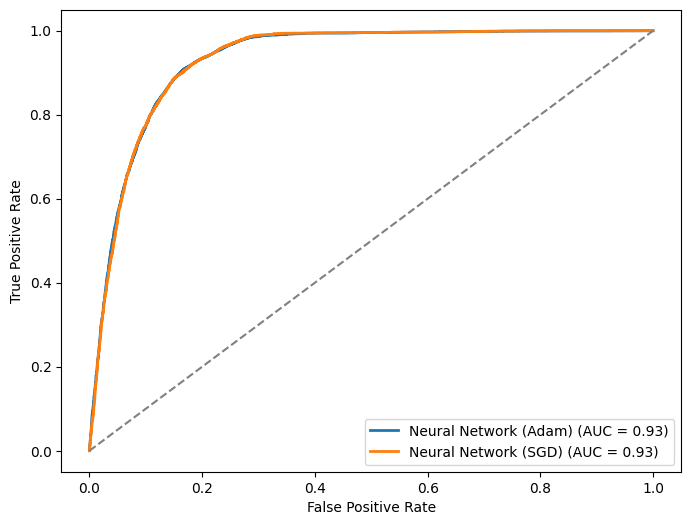

In [21]:
plot_roc_curves(y_test, [
    (adam_model.predict(X_std_test).ravel(), 'Neural Network (Adam)'),
    (sgd_model.predict(X_std_test).ravel(), 'Neural Network (SGD)')
])


# With SMOTE

We'll try now to use SMOTE to balance the dataset and have a 50-50 ratio of incidents with and without killings.
Then we'll retry the best classifiers on this new dataset to see if there are substantial differences.

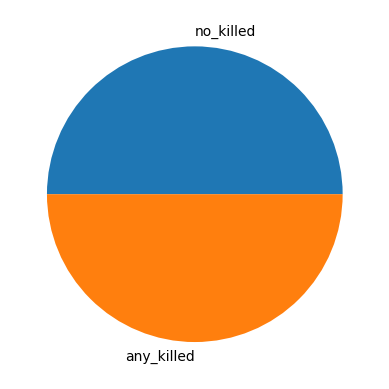

In [23]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

plt.pie(y.value_counts(), labels=labels)
plt.show()

In [24]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=seed, test_size=0.15, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=seed, test_size=0.18, stratify=y_dev)

print('Dev set size:', len(y_dev), '- Killing ratio:', round(np.count_nonzero(y_dev) / len(y_dev), 2))
print('     Train set size:', len(y_train), '- Killing ratio:', round(np.count_nonzero(y_train) / len(y_train), 2))
print('     Validation set size:', len(y_val), '- Killing ratio:', round(np.count_nonzero(y_val) / len(y_val), 2))
print('Test set size:', len(y_test), '- Killing ratio:', round(np.count_nonzero(y_test) / len(y_test), 2))

Dev set size: 193296 - Killing ratio: 0.5
     Train set size: 158502 - Killing ratio: 0.5
     Validation set size: 34794 - Killing ratio: 0.5
Test set size: 34112 - Killing ratio: 0.5


In [25]:
scaler = StandardScaler()
X_std_dev = scaler.fit_transform(X_dev)
X_std_train = scaler.fit_transform(X_train)
X_std_val = scaler.fit_transform(X_val)
X_std_test = scaler.fit_transform(X_test)

# ravel() is used to convert the y arrays from 2D to 1D
y_dev = y_dev.values.ravel()
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

Retry the best classifier on a more balanced dataset

In [25]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_std_train, y_train)
acc_tr = knn.score(X_std_dev, y_dev)
acc_val = knn.score(X_std_test, y_test)
print(f"Training accuracy: {acc_tr}")
print(f"Test accuracy: {acc_val}")

Training accuracy: 0.8982544905223078
Test accuracy: 0.8832668855534709


In [26]:
bnb = BernoulliNB()
y_pred = bnb.fit(X_std_dev, y_dev).predict(X_std_test)
print(classification_report(y_pred, y_test, target_names=labels))

              precision    recall  f1-score   support

   no_killed       0.77      0.74      0.75     17582
  any_killed       0.74      0.76      0.75     16530

    accuracy                           0.75     34112
   macro avg       0.75      0.75      0.75     34112
weighted avg       0.75      0.75      0.75     34112


In [26]:
from sklearn.tree import DecisionTreeClassifier

dt_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}
best_score_dt, best_decision_tree = grid_search(DecisionTreeClassifier(), X_std_dev, y_dev, dt_params)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best parameters set found:
{'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best accuracy score found:
0.8862780255130327


In [27]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=None, min_samples_leaf=1,
                                       min_samples_split=2,
                                       splitter='best')
print("Same Parameters: " + decision_tree.fit(X_std_dev, y_dev).score(X_std_test, y_test))
print("Updated Parameters: " + best_decision_tree.fit(X_std_dev, y_dev).score(X_std_test, y_test))

0.8453037054409006


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': ['sqrt', 'log2']
}
best_score_rf, best_random_forest = grid_search(RandomForestClassifier(), X_std_dev, y_dev, rf_params)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


In [ ]:
random_forest = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=150)
print("Same Parameters: " + random_forest.fit(X_std_dev, y_dev).score(X_std_test, y_test))
print("Updated Parameters: " + best_random_forest.fit(X_std_dev, y_dev).score(X_std_test, y_test))

In [34]:
chosen_svm = svms.LinearSVC(penalty='l2', dual='auto', C=5, loss='hinge')
print(chosen_svm.fit(X_std_dev, y_dev).score(X_std_test, y_test))

0.8589939024390244


C:\Users\Hp\Desktop\DataMining\env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Epoch 1/150
496/496 - 4s - loss: 0.5518 - accuracy: 0.7389 - val_loss: 0.4387 - val_accuracy: 0.8516 - lr: 1.0000e-04 - 4s/epoch - 8ms/step
Epoch 2/150
496/496 - 1s - loss: 0.4200 - accuracy: 0.8525 - val_loss: 0.3852 - val_accuracy: 0.8575 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 3/150
496/496 - 2s - loss: 0.3759 - accuracy: 0.8583 - val_loss: 0.3463 - val_accuracy: 0.8619 - lr: 1.0000e-04 - 2s/epoch - 3ms/step
Epoch 4/150
496/496 - 2s - loss: 0.3461 - accuracy: 0.8622 - val_loss: 0.3235 - val_accuracy: 0.8642 - lr: 1.0000e-04 - 2s/epoch - 4ms/step
Epoch 5/150
496/496 - 1s - loss: 0.3317 - accuracy: 0.8632 - val_loss: 0.3129 - val_accuracy: 0.8663 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 6/150
496/496 - 1s - loss: 0.3228 - accuracy: 0.8667 - val_loss: 0.3072 - val_accuracy: 0.8678 - lr: 1.0000e-04 - 1s/epoch - 2ms/step
Epoch 7/150
496/496 - 1s - loss: 0.3168 - accuracy: 0.8690 - val_loss: 0.3041 - val_accuracy: 0.8695 - lr: 1.0000e-04 - 1s/epoch - 2ms/step
Epoch 8/150
496/496 

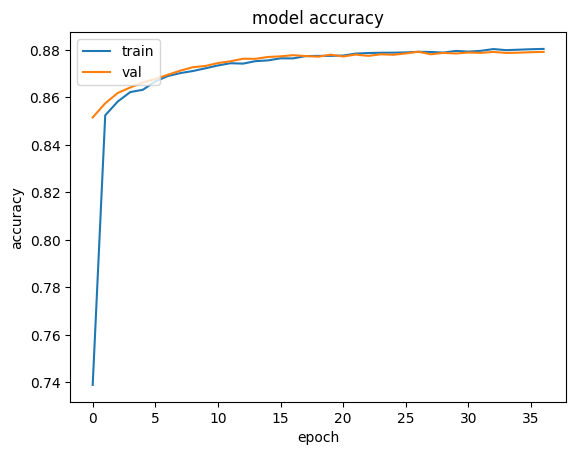

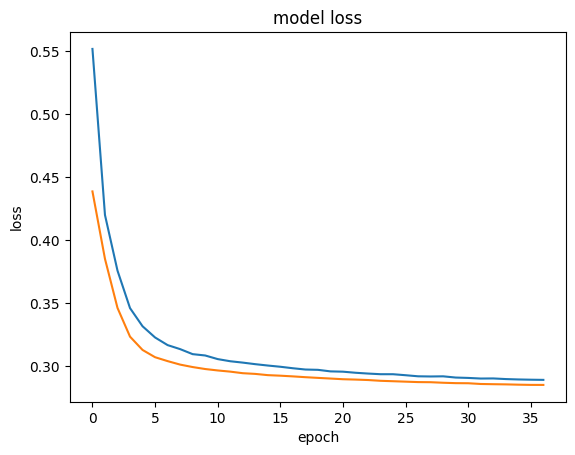

1066/1066 [==============================] - 2s 2ms/step - loss: 0.2773 - accuracy: 0.8870
[0.2773175537586212, 0.8869898915290833]


In [35]:
from keras.optimizers import Adam

history, adam_model = keras_mlp(X_std_train, y_train, X_std_val, y_val,
                                Adam(learning_rate=1e-4), activation="tanh",
                                dropout=0.3, epochs=150)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

eval = adam_model.evaluate(X_std_test, y_test)
print(eval)


1066/1066 [==============================] - 2s 1ms/step


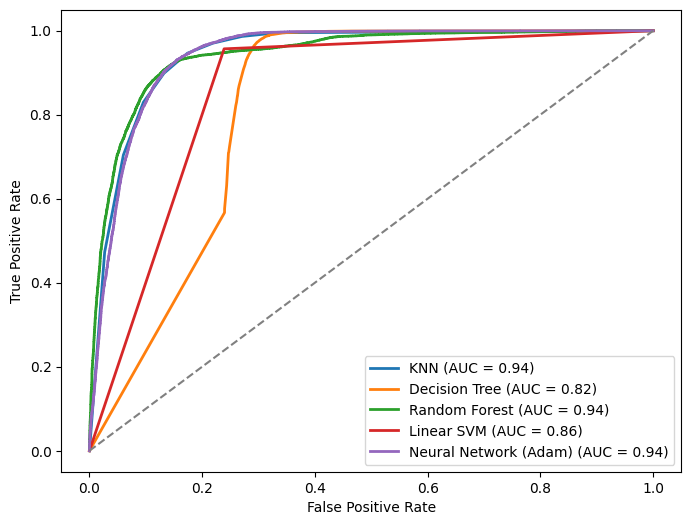

In [36]:
rocs = [
    (knn.predict_proba(X_std_test)[:, 1], 'KNN'),
    (decision_tree.predict_proba(X_std_test)[:, 1], 'Decision Tree'),
    (random_forest.predict_proba(X_std_test)[:, 1], 'Random Forest'),
    (chosen_svm.predict(X_std_test), 'Linear SVM'),
    (adam_model.predict(X_std_test).ravel(), 'Neural Network (Adam)')
]

plot_roc_curves(y_test, rocs)
